In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
from collections import defaultdict

S:\anaconda3\envs\hh_casualml_test\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# ================ 1. ЗАГРУЗКА ДАННЫХ ================
print("Загрузка данных...")
triggers = pd.read_csv('triggers.csv', parse_dates=['date'])
actions = pd.read_csv('actions.csv', parse_dates=['date'])

# Определяем max_date для окон
max_date = max(triggers['date'].max(), actions['date'].max())

Загрузка данных...


In [3]:
# ================ 2. ПОДГОТОВКА ПРИЗНАКОВ ================
print("Подготовка признаков...")

def aggregate_features(df, by, date_col, windows, col, max_date):
    """Агрегация признаков по временным окнам"""
    chunks = []
    for w in tqdm(windows, desc=f'agg {col} windows'):
        start = max_date - pd.Timedelta(days=w)
        df_w = df[df[date_col] >= start]
        agg = (
            df_w
            .groupby(by)[col]
            .agg(count='count', unique='nunique')
            .rename(columns={
                'count': f'count_{w}d',
                'unique': f'unique_{w}d'
            })
        )
        chunks.append(agg)
    return pd.concat(chunks, axis=1).fillna(0)

# Строим фичи из triggers
windows = [3, 7, 14, 30, 60]  # Добавлены окна 3 и 60 дней
f_tr = aggregate_features(triggers, 'guid', 'date', windows, 'trigger', max_date)
f_ty = aggregate_features(triggers, 'guid', 'date', windows, 'type', max_date)

# Добавляем префиксы
f_tr = f_tr.add_prefix('tr_')
f_ty = f_ty.add_prefix('ty_')

# Агрегация признаков из actions
act_agg = (
    actions
    .groupby('guid')
    .agg(
        shows_count=('date', 'count'),
        positive_shows=('result', 'sum'),
        last_show=('date', 'max')
    )
)
act_agg['days_since_last_show'] = (
        max_date - act_agg['last_show']
).dt.days.fillna(999)

# Объединяем все признаки
features = (
    f_tr
    .join(f_ty, how='outer')
    .join(act_agg, how='outer')
    .fillna({
        'shows_count': 0,
        'positive_shows': 0,
        'days_since_last_show': 999
    })
)
features['user_ctr'] = (
        features['positive_shows'] / features['shows_count'].replace(0, 1)
)

# Добавляем recency из triggers
last_visit = triggers.groupby('guid')['date'].max()
features['days_since_last_visit'] = (
        max_date - last_visit
).dt.days.fillna(999)

# Добавляем временные фичи
features['last_visit_weekday'] = last_visit.dt.weekday
features['last_visit_hour'] = last_visit.dt.hour
features['last_visit_month'] = last_visit.dt.month

# Добавляем взаимодействия между признаками
for w in windows:
    features[f'tr_ty_ratio_{w}d'] = features[f'tr_count_{w}d'] / features[f'ty_count_{w}d'].replace(0, 1)
    features[f'tr_unique_ratio_{w}d'] = features[f'tr_unique_{w}d'] / features[f'tr_count_{w}d'].replace(0, 1)

# Добавляем скоростные признаки (изменение активности)
for w1, w2 in [(3, 7), (7, 14), (14, 30), (30, 60)]:
    features[f'tr_speed_{w1}_{w2}d'] = features[f'tr_count_{w1}d'] / features[f'tr_count_{w2}d'].replace(0, 1)
    features[f'ty_speed_{w1}_{w2}d'] = features[f'ty_count_{w1}d'] / features[f'ty_count_{w2}d'].replace(0, 1)

# Сохраняем признаки
features.reset_index().to_csv('features_enhanced.csv', index=False)
print(f"Признаки сохранены, размер: {features.shape}")

Подготовка признаков...


agg trigger windows:   0%|          | 0/5 [00:00<?, ?it/s]

agg type windows:   0%|          | 0/5 [00:00<?, ?it/s]

Признаки сохранены, размер: (1020845, 47)


In [4]:
# ================ 3. ПОДГОТОВКА ДАННЫХ ДЛЯ ОБУЧЕНИЯ ================
print("Подготовка данных для обучения...")

# Разделим данные на две группы по времени (не случайно!)
# Берем первые 80% дней для обучения, последние 20% для тестирования
print("Разделение данных по времени...")
all_dates = sorted(actions['date'].unique())
split_idx = int(len(all_dates) * 0.8)
train_dates = all_dates[:split_idx]
test_dates = all_dates[split_idx:]

# Добавляем информацию о дне недели/часе/месяце в actions
actions['weekday'] = actions['date'].dt.weekday
actions['hour'] = actions['date'].dt.hour
actions['month'] = actions['date'].dt.month

# Формируем выборки с учетом временного разделения
train_actions = actions[actions['date'].isin(train_dates)]
test_actions = actions[actions['date'].isin(test_dates)]

# Соединяем признаки с метками
feat = pd.read_csv('features_enhanced.csv')

# Определяем признаки, которые будем использовать
# (исключаем признаки, которые могут быть недоступны в реальном времени)
available_features = [col for col in feat.columns if col not in [
    'guid', 'last_show', 'shows_count', 'positive_shows',
    'days_since_last_show', 'user_ctr'
]]

# Создаем тренировочную и тестовую выборки
train_df = feat.merge(train_actions[['guid', 'date', 'result', 'weekday', 'hour', 'month']], on='guid')
test_df = feat.merge(test_actions[['guid', 'date', 'result', 'weekday', 'hour', 'month']], on='guid')

# Проверяем, что в тестовых данных нет информации из обучающей выборки
test_df = test_df.drop(columns=[
    'shows_count', 'positive_shows', 'user_ctr', 'days_since_last_show'
])

# Готовим X и y
X_train = train_df[available_features]
y_train = train_df['result']
X_test = test_df[available_features]
y_test = test_df['result']

print(f"Распределение классов в обучающей выборке:")
print(y_train.value_counts(normalize=True))

Подготовка данных для обучения...
Разделение данных по времени...
Распределение классов в обучающей выборке:
result
0    0.970426
1    0.029574
Name: proportion, dtype: float64


In [27]:
# ================ 4. РЕШЕНИЕ ПРОБЛЕМЫ ДИСБАЛАНСА И ОБУЧЕНИЕ МОДЕЛИ ================
print("Решение проблемы дисбаланса классов и обучение модели...")

# # Применяем комбинированный resampling (SMOTE + Tomek Links)
# smote_tomek = SMOTETomek(random_state=42)
# X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)
# print(f"Размер ресэмплированной выборки: {X_resampled.shape}")
# print(f"Распределение классов после ресэмплинга:")
# print(pd.Series(y_resampled).value_counts(normalize=True))

# Параметры для балансировки классов
ratio = (y_train == 0).sum() / (y_train == 1).sum()

# Создаем разбиение для валидации
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

Решение проблемы дисбаланса классов и обучение модели...


In [28]:
# Обучение модели с валидацией для предотвращения переобучения
print("Обучение XGBoost...")
model = XGBClassifier(
    eval_metric='aucpr',  # AUC PR curve вместо logloss
    scale_pos_weight=0.2,   # Т.к. мы уже сбалансировали выборку
    n_estimators=100,
    max_depth=7,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=2,
    gamma=0.1,
    reg_alpha=0.2,
    reg_lambda=2,
    early_stopping_rounds=100
)
model.fit(
    X_train_split, y_train_split,
    eval_set=[(X_val, y_val)],
    verbose=100
)

# Калибровка вероятностей для получения более реалистичных прогнозов
print("Калибровка вероятностей...")
calibrated_model = CalibratedClassifierCV(
    model,
    method='isotonic',
    cv='prefit'
)
calibrated_model.fit(X_val, y_val)

Обучение XGBoost...
[0]	validation_0-aucpr:0.05251
[99]	validation_0-aucpr:0.07773
Калибровка вероятностей...


CalibratedClassifierCV(cv='prefit',
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=0.8,
                                               device=None,
                                               early_stopping_rounds=100,
                                               enable_categorical=False,
                                               eval_metric='aucpr',
                                               feature_types=None, gamma=0.1,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=0.03, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None, max_depth=7,
                                               max_leaves=None,
                                               min_child_weight=2, missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=100, n_jobs=None,
                                               num_parallel_tree=None,
                                               random_state=None, ...),
                       method='isotonic')

Оценка модели...
ROC-AUC на тестовой выборке: 0.6829
PR-AUC на тестовой выборке: 0.0772


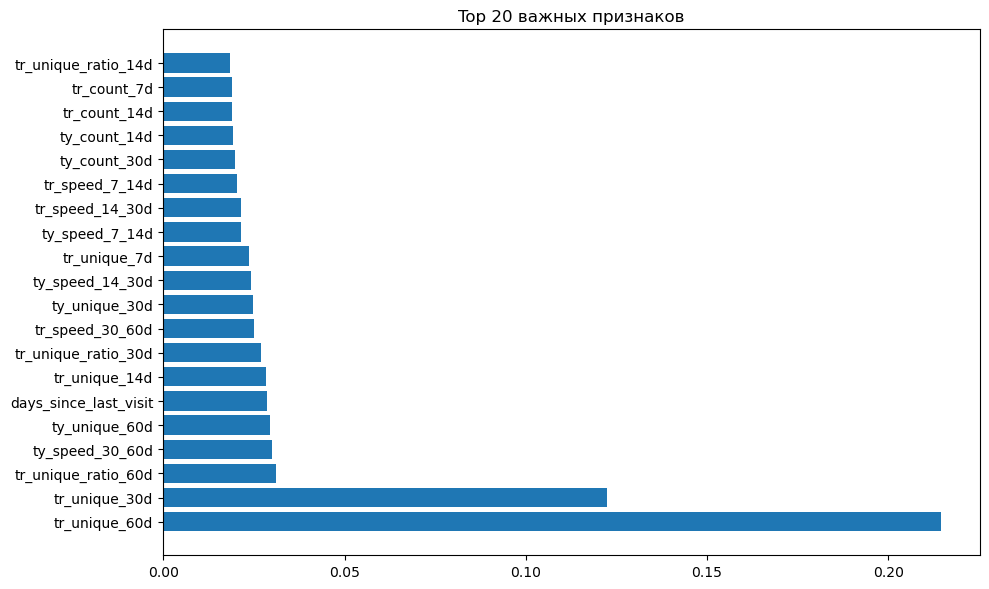

In [29]:
# ================ 5. ОЦЕНКА МОДЕЛИ ================
print("Оценка модели...")

# Предсказания на тестовой выборке
y_proba = calibrated_model.predict_proba(X_test)[:, 1]
roc = roc_auc_score(y_test, y_proba)
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

print(f"ROC-AUC на тестовой выборке: {roc:.4f}")
print(f"PR-AUC на тестовой выборке: {pr_auc:.4f}")

# Анализ важности признаков
feature_importance = pd.DataFrame({
    'Feature': available_features,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False).head(20)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.title('Top 20 важных признаков')
plt.tight_layout()
plt.savefig('feature_importance.png')

In [30]:
# ================ 6. СИМУЛЯЦИЯ КАМПАНИИ С РЕАЛЬНЫМИ ДАННЫМИ ================
print("Симуляция кампании с реальными данными...")

def business_metric(y_true, y_pred, threshold=0.2):
    """Оценка модели по финансовым показателям"""
    pred = (y_pred >= threshold).astype(int)
    tp = sum((pred == 1) & (y_true == 1))  # успешные конверсии
    fp = sum((pred == 1) & (y_true == 0))  # неуспешные показы

    shows = tp + fp
    conversions = tp

    revenue = conversions * 5  # $5 за конверсию
    cost = shows  # $1 за показ
    balance = revenue - cost
    turnover = revenue + cost

    return {
        'shows': shows,
        'conversions': conversions,
        'revenue': revenue,
        'cost': cost,
        'balance': balance,
        'turnover': turnover,
        'conversion_rate': conversions/shows if shows > 0 else 0
    }

def simulate_campaign_with_real_data(thresholds, model, freq_days=14):
    """
    Оптимизированная симуляция кампании с использованием реальных данных конверсии
    с учетом сегментации пользователей
    """
    results = []

    # 1. Предварительный расчет вероятностей для всех пользователей
    print("Расчет вероятностей для всех пользователей...")
    unique_users = test_df.drop_duplicates('guid')
    print(f"Количество уникальных пользователей: {len(unique_users)}")
    X_pred = unique_users[available_features]
    with tqdm(total=1, desc="Batch prediction") as pbar:
        probas = model.predict_proba(X_pred)[:, 1]
        pbar.update(1)

    # 2. Сегментируем пользователей на 3 группы по активности
    unique_users['probability'] = probas
    # Используем количество посещений за 30 дней как меру активности
    if 'tr_count_30d' in unique_users.columns:
        unique_users['activity_segment'] = pd.qcut(
            unique_users['tr_count_30d'],
            q=3,
            labels=['low', 'medium', 'high']
        ).fillna('low')
    else:
        unique_users['activity_segment'] = 'medium'  # Если признак отсутствует

    guid_to_info = dict(zip(
        unique_users['guid'],
        zip(unique_users['probability'], unique_users['activity_segment'])
    ))

    # 3. Подготовка данных о посещениях и конверсиях
    print("Подготовка данных о посещениях и конверсиях...")
    guid_results = defaultdict(list)
    for _, row in test_actions.iterrows():
        guid = row['guid']
        if guid in guid_to_info:
            guid_results[guid].append((row['date'], row['result']))

    # 4. Формирование полного списка событий
    print("Формирование полного списка событий...")
    all_events = []
    for guid, events in guid_results.items():
        prob, segment = guid_to_info[guid]
        for date, result in events:
            all_events.append((date, guid, result, prob, segment))
    all_events.sort()

    # 5. Запуск симуляции для каждого базового порога
    for base_threshold in tqdm(thresholds, desc="Симуляция для порогов"):
        # Адаптируем пороги для разных сегментов
        segment_thresholds = {
            'low': base_threshold * 1.2,     # Более высокий порог для неактивных
            'medium': base_threshold,         # Базовый порог для средних
            'high': base_threshold * 0.8      # Более низкий порог для активных
        }

        # Предварительно фильтруем события по адаптивным порогам
        filtered_events = []
        for date, guid, result, prob, segment in all_events:
            segment_threshold = segment_thresholds[segment]
            if prob >= segment_threshold:
                filtered_events.append((date, guid, result, segment))

        # Симуляция показов с учетом частотного ограничения
        total_shows = 0
        total_conversions = 0
        last_shown = {}
        segment_stats = {segment: {'shows': 0, 'conversions': 0} for segment in ['low', 'medium', 'high']}

        for date, guid, result, segment in filtered_events:
            if guid in last_shown:
                days_since_last = (date - last_shown[guid]).days
                if days_since_last < freq_days:
                    continue

            total_shows += 1
            last_shown[guid] = date
            segment_stats[segment]['shows'] += 1

            if result == 1:
                total_conversions += 1
                segment_stats[segment]['conversions'] += 1

        # Расчет экономических метрик
        spend = total_shows
        revenue = total_conversions * 5
        balance = revenue - spend
        turnover = revenue + spend

        # Сохраняем результаты
        results.append({
            'base_threshold': base_threshold,
            'shows': total_shows,
            'conversions': total_conversions,
            'spend': spend,
            'revenue': revenue,
            'balance': balance,
            'turnover': turnover,
            'conv_rate': total_conversions / total_shows if total_shows > 0 else 0,
            'low_conv_rate': segment_stats['low']['conversions'] / segment_stats['low']['shows']
            if segment_stats['low']['shows'] > 0 else 0,
            'medium_conv_rate': segment_stats['medium']['conversions'] / segment_stats['medium']['shows']
            if segment_stats['medium']['shows'] > 0 else 0,
            'high_conv_rate': segment_stats['high']['conversions'] / segment_stats['high']['shows']
            if segment_stats['high']['shows'] > 0 else 0
        })

    return pd.DataFrame(results)

# Генерируем список порогов для проверки
thresholds = np.linspace(0.001, 0.95, 20)
simulation_results = simulate_campaign_with_real_data(thresholds, calibrated_model)

Симуляция кампании с реальными данными...
Расчет вероятностей для всех пользователей...
Количество уникальных пользователей: 107461


Batch prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Подготовка данных о посещениях и конверсиях...
Формирование полного списка событий...


Симуляция для порогов:   0%|          | 0/20 [00:00<?, ?it/s]

In [31]:
# ================ 7. АНАЛИЗ РЕЗУЛЬТАТОВ ================
print("Анализ результатов симуляции...")

# Отбираем только варианты с положительным балансом
profitable = simulation_results[simulation_results['balance'] >= 0]

if len(profitable) > 0:
    # Находим порог с максимальным оборотом при положительном балансе
    best_row = profitable.loc[profitable['turnover'].idxmax()]
    best_threshold = best_row['base_threshold']

    print("\n=== ОПТИМАЛЬНЫЙ ПОРОГ ДЛЯ МАКСИМИЗАЦИИ ОБОРОТА ===")
    print(f"Базовый порог вероятности: {best_threshold:.4f}")
    print(f"Показы: {best_row['shows']}")
    print(f"Конверсии: {best_row['conversions']}")
    print(f"Расходы: ${best_row['spend']}")
    print(f"Доходы: ${best_row['revenue']}")
    print(f"Баланс: ${best_row['balance']}")
    print(f"Оборот: ${best_row['turnover']}")
    print(f"Общая конверсия: {best_row['conv_rate']:.2%}")
    print(f"Конверсия по сегментам:")
    print(f"  - Низкая активность: {best_row['low_conv_rate']:.2%}")
    print(f"  - Средняя активность: {best_row['medium_conv_rate']:.2%}")
    print(f"  - Высокая активность: {best_row['high_conv_rate']:.2%}")
else:
    print("Не найдено вариантов с положительным балансом.")

Анализ результатов симуляции...

=== ОПТИМАЛЬНЫЙ ПОРОГ ДЛЯ МАКСИМИЗАЦИИ ОБОРОТА ===
Базовый порог вероятности: 0.2008
Показы: 543.0
Конверсии: 109.0
Расходы: $543.0
Доходы: $545.0
Баланс: $2.0
Оборот: $1088.0
Общая конверсия: 20.07%
Конверсия по сегментам:
  - Низкая активность: 0.00%
  - Средняя активность: 0.00%
  - Высокая активность: 20.07%
